<a href="https://colab.research.google.com/github/shubhamk16/Deep_learning/blob/master/L1_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-2.0, 2.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             864
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             120
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,080
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

In [0]:
from tqdm import tqdm_notebook,tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_loss(x):
  return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  criterion = nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred,target)
    reg_loss= 0
    to_regularize = []
    for param in model.parameters():
      to_regularize.append(param.view(-1))
    factor = 0.005
    reg_loss = factor * l1_loss(torch.cat(to_regularize))
    loss += factor * reg_loss  
    
    #loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  #all_linear1_params = torch.cat([x.view(-1) for x in model.linear1.parameters()])
  #all_linear2_params = torch.cat([x.view(-1) for x in model.linear2.parameters()])
  #l1_regularization = lambda1 * torch.norm(all_linear1_params, 1)
  #l2_regularization = lambda2 * torch.norm(all_linear2_params, 2)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.13568279147148132 Batch_id=468 Accuracy=87.16: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0819, Accuracy: 9774/10000 (97.74%)

EPOCH: 1


Loss=0.06360344588756561 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9856/10000 (98.56%)

EPOCH: 2


Loss=0.13001739978790283 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:13<00:00, 35.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9842/10000 (98.42%)

EPOCH: 3


Loss=0.1512787789106369 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:12<00:00, 36.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


Loss=0.04010438174009323 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:12<00:00, 36.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.03355884179472923 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.08096423000097275 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9901/10000 (99.01%)

EPOCH: 7


Loss=0.042423248291015625 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.06674990057945251 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 35.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.037381015717983246 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9907/10000 (99.07%)

EPOCH: 10


Loss=0.03524346649646759 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 35.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.02280018851161003 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 34.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9911/10000 (99.11%)

EPOCH: 12


Loss=0.07945401966571808 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.034661099314689636 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.036539122462272644 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


Loss=0.044458549469709396 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.051162444055080414 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 35.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.028452713042497635 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.042234230786561966 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.03602021932601929 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.14635854959487915 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.030238881707191467 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

EPOCH: 22


Loss=0.04671759903430939 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.028458882123231888 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 42.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH: 24


Loss=0.026311907917261124 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 35.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 25


Loss=0.04758700728416443 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 34.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9925/10000 (99.25%)

EPOCH: 26


Loss=0.07334005832672119 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 27


Loss=0.058386221528053284 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 34.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

EPOCH: 28


Loss=0.0380282923579216 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 35.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 29


Loss=0.026276670396327972 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 30


Loss=0.049102433025836945 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 35.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9941/10000 (99.41%)

EPOCH: 31


Loss=0.07967457175254822 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH: 32


Loss=0.022945204749703407 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 35.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 33


Loss=0.05086556449532509 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.29%)

EPOCH: 34


Loss=0.02638249471783638 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 35.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)

EPOCH: 35


Loss=0.049457989633083344 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9938/10000 (99.38%)

EPOCH: 36


Loss=0.09428500384092331 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 35.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9943/10000 (99.43%)

EPOCH: 37


Loss=0.04185307398438454 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

EPOCH: 38


Loss=0.03900205343961716 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH: 39


Loss=0.04022921621799469 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.90it/s]



Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)



Text(0.5, 1.0, 'Test Accuracy')

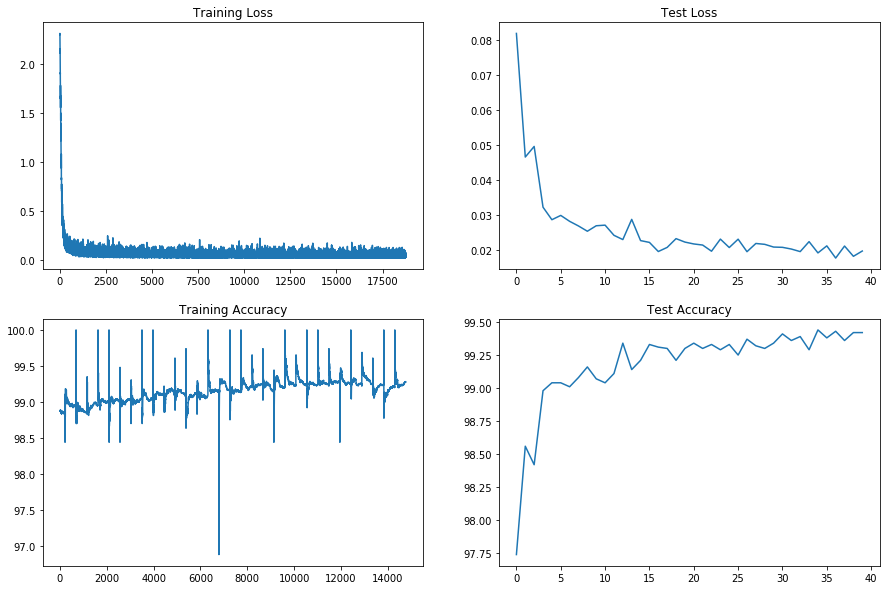

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")